## Bitcoin Price

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

from mod_btc import crosscorr, plot_correlation

In [4]:
btc = pd.read_csv('BTC-USD.csv', low_memory=False)
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [5]:
tweets = pd.read_csv('tweets_scores.csv', low_memory=False)

In [6]:
btc.Date = pd.to_datetime(btc.Date)

<AxesSubplot:>

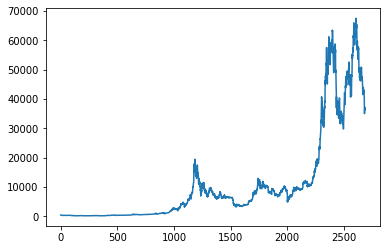

In [7]:
btc['Adj Close'].plot()

In [8]:
tweets = tweets.drop_duplicates()
tweets['date'] = pd.to_datetime(tweets['date'])
tweets.index = tweets['date']

In [9]:
tweets_grouped = tweets.resample('1h').sum()

In [10]:
btc_usd = btc.copy()
btc_usd['Date'] = pd.to_datetime(btc_usd['Date'], unit='s')
btc_usd.index = btc_usd['Date']

In [11]:
btc_usd_grouped = btc_usd.resample('D')['Adj Close'].mean()

## Plot tweets scores and BTC price

In [12]:
beg = max(tweets_grouped.index.min().replace(tzinfo=None),
          btc_usd_grouped.index.min())

end = min(tweets_grouped.index.max().replace(tzinfo=None),
          btc_usd_grouped.index.max())

tweets_grouped = tweets_grouped[beg:end]
btc_usd_grouped = btc_usd_grouped[beg:end]

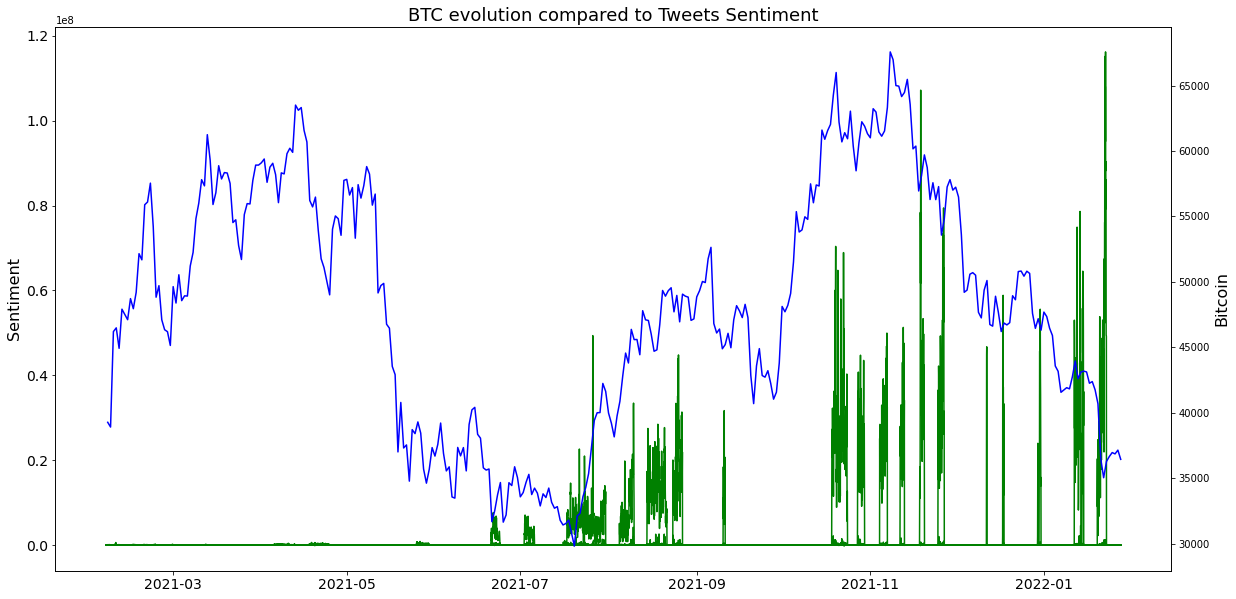

In [13]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title('BTC evolution compared to Tweets Polarization', fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot(tweets_grouped, 'g-')
ax2.plot(btc_usd_grouped, 'b-')
# ax2.axis_date(btc_usd_grouped.index, btc_usd_grouped, 'b-')

ax1.set_ylabel('Sentiment', fontsize=16)
ax2.set_ylabel('Bitcoin', fontsize=16)
plt.show()

# Meter leyenda!

### Save data to local

In [36]:
tweets_grouped.to_csv('tweets_grouped_03.csv')
btc_usd_grouped.to_csv('btc_grouped_03.csv')

## Correlations

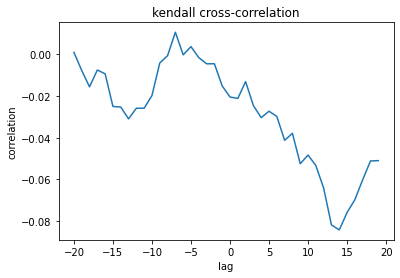

In [44]:
plot_correlation(tweets = tweets_grouped,
                 bitcoin = btc_usd_grouped,
                 method = 'kendall')

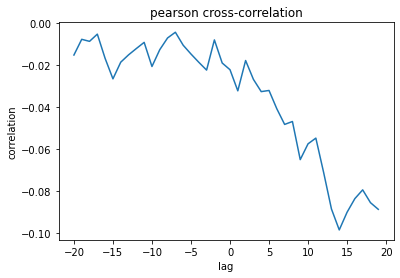

In [45]:
plot_correlation(tweets = tweets_grouped,
                 bitcoin = btc_usd_grouped,
                 method = 'pearson')

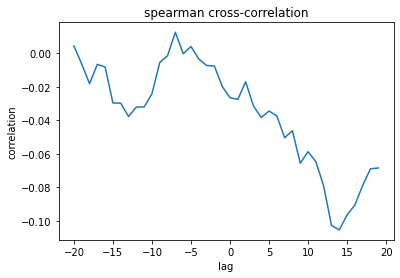

In [46]:
plot_correlation(tweets = tweets_grouped,
                 bitcoin = btc_usd_grouped,
                 method = 'spearman')

## Normalization